In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-03bffc2b-c48b-744d-c7f6-8452bbc6c097)
GPU 1: Tesla T4 (UUID: GPU-ab9b0cc9-1e4e-d757-a91a-a785a5da5249)


# Installs

In [2]:
! pip install langchain

In [3]:
# %%time

# ! pip install -qq -U langchain tiktoken pypdf chromadb faiss-gpu
# ! pip install -qq -U transformers InstructorEmbedding sentence_transformers
# ! pip install -qq -U accelerate bitsandbytes xformers einops

In [4]:
%%time

#!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git

!pip install -q -U tiktoken pypdf chromadb faiss-gpu
!pip install -q datasets bitsandbytes einops wandb xformers einops
!pip install InstructorEmbedding sentence_transformers

CPU times: user 646 ms, sys: 100 ms, total: 746 ms
Wall time: 38.2 s


In [5]:
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-_3odclfe
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-_3odclfe
  Resolved https://github.com/huggingface/transformers.git to commit 0b568291d722aa5e39cd4a8fa05c03200dd280ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-sqaa5z0i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-sqaa5z0i
  Resolved https://github.com/huggingface/accelerate.git to commit 64c586f5eb52c86f045b1d46202c60fbbdbdd9c9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, ConversationChain, LLMChain

# vector stores
from langchain.vectorstores import Chroma, FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA, ConversationalRetrievalChain

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

print(langchain.__version__)

0.0.266


In [7]:
glob.glob('/kaggle/input/medical-chatbot-dataset/*')

['/kaggle/input/medical-chatbot-dataset/validation_data_chatbot.csv',
 '/kaggle/input/medical-chatbot-dataset/train_data_chatbot.csv']

# CFG

- CFG class enables easy and organized experimentation 

In [8]:
class CFG:
    # LLMs
    model_name = 'llama2-7b' # wizardlm, bloom, falcon, llama2-7b, llama2-13b
    temperature = 0,
    top_p = 0.95,
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'hkunlp/instructor-base'    

    # similar passages
    k = 3
    
    # paths
    PDFs_path = '/kaggle/input/medbooks/'
    
    Embeddings_path =  '/kaggle/working/medbooks-vectordb-chroma'
    Persist_directory = './medbooks-vectordb-chroma'  

# Define model

In [9]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'llama2-7b':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )
        
        max_len = 2048

    elif model == 'llama2-13b':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )
        
        max_len = 8192
        
    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [10]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 26.4 s, sys: 47.2 s, total: 1min 13s
Wall time: 5min 33s


In [11]:
max_len

2048

# pipeline

In [12]:
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

llm = HuggingFacePipeline(pipeline = pipe)

In [13]:
llm

HuggingFacePipeline(cache=None, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7d490de63e50>, model_id='gpt2', model_kwargs=None, pipeline_kwargs=None)

In [14]:
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of child diseases"
llm(query)

" that are preventable through vaccination. Unterscheidung between the two is important to avoid confusion and ensure accurate diagnosis and treatment. The most common causes of fever in children are viral infections, such as the common cold or flu. Vaccines have been instrumental in controlling and eliminating many infectious diseases that were once common and deadly, such as smallpox, polio, measles, mumps, rubella (German measles), and bacterial meningitis. In addition to these vaccine-preventable diseases, there are other types of illnesses that can cause a fever in children, including: 1. Viral gastroenteritis (stomach flu) - This is an infection of the stomach and intestines caused by a virus. Fever in children can be caused by a variety of factors, including infections, inflammation, and reactions to medications. Here are some examples of childhood diseases that can cause a fever: 1. Viral respiratory infections - These include colds, flu, and other upper respiratory tract infec

# Using Langchain

In [15]:
CFG.model_name

'llama2-7b'

In [17]:
%%time

loader = DirectoryLoader(CFG.PDFs_path, 
                         glob="./*.pdf",
                         loader_cls=PyPDFLoader,
                         show_progress=True,
                         use_multithreading=True)

documents = loader.load()

100%|██████████| 13/13 [07:35<00:00, 35.01s/it]

CPU times: user 7min 24s, sys: 28 s, total: 7min 52s
Wall time: 7min 35s


In [18]:
len(documents)

5946

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = CFG.split_chunk_size,
                                               chunk_overlap = CFG.split_overlap)

texts = text_splitter.split_documents(documents)
len(texts)

19255

## Embeddings

## Create vector database

In [20]:
%%time

### download embeddings model
instructor_embeddings = HuggingFaceInstructEmbeddings(model_name = CFG.embeddings_model_repo,
                                                      model_kwargs = {"device": "cuda"})

### create embeddings and DB
vectordb = Chroma.from_documents(documents = texts,
                                 embedding = instructor_embeddings,
                                 persist_directory = CFG.Persist_directory,
                                 collection_name = 'hp_books')

# vectordb.add_documents(documents=texts, embedding=instructor_embeddings)

### persist Chroma vector database
vectordb.persist()

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 8min 17s, sys: 3.8 s, total: 8min 21s
Wall time: 8min 18s


## Load vector database

In [21]:
%%time

### download embeddings model
instructor_embeddings = HuggingFaceInstructEmbeddings(model_name = CFG.embeddings_model_repo,
                                                      model_kwargs = {"device": "cuda"})

vectordb = Chroma(persist_directory = CFG.Embeddings_path,
                  embedding_function = instructor_embeddings,
                  collection_name = 'hp_books')

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 1.33 s, sys: 526 ms, total: 1.85 s
Wall time: 1.87 s


In [22]:
### how many documents were loaded
print(vectordb._collection.count())

19255


# Prompt Template


In [23]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template=prompt_template, 
    input_variables=["context", "question"]
)

# Retriever chain

In [25]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(llm = llm,
                                       chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
                                       retriever = retriever, 
                                       chain_type_kwargs = {"prompt": PROMPT},
                                       return_source_documents = True,
                                       verbose = False)

In [26]:
### testing MMR search
question = "Si j'ai des maux de tête, comment faire?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='junale pour une tumeur de la tête du pancréas non résécable.', metadata={'page': 284, 'source': '/kaggle/input/medbooks/iKB Hepato-Gastro-Enterologie 2018 MEDLIFE .pdf'}),
 Document(page_content="•Bien entendu, vos critiques seront toujours acceptées avec plaisir afin d'amél iorer la qualité\ndidactique de cet ouvrage.\n335", metadata={'page': 367, 'source': '/kaggle/input/medbooks/iKB Endocrinologie Diabetologie 2018 MEDLIFE.pdf'}),
 Document(page_content="doit être parfaitement immobile (anesthésie requise). \nJouets de Moatti : \nLes 4 boîtes de Moatti couvrent l'étendue du champ auditif nécessaire à la compréhension de la \nparole et délivrent un bruit calibré de 60 dB à 2 m quelle que soit la manière dont on les manipule. \nMais on peut aussi utiliser différents jouets du commerce : crécelle, maracas, cliquets, clochettes, \nboîtes musicales. \nLe jouet sonore est agité hors de son champ de vision. La réaction attendue est une déviation de la \ntête ou simp

In [27]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content="pas de récidive possible Enanthème macules rouges Description sémiologique (cf. chapitre «exanthèmes ») ou pétéchies du voile du -exanthème : érythème cutané qui s'efface à la vitropression palais -enanthème : érythème de muqueuse (surtout oropharynx) Mégalérythème Incubation : 4-14 J Age : 5 à 1 0 ans + adultes -exanthème morbilliforme : macules (ou macula-papules) non confluentes, épidémique ou Prodrome : rougeur Fièvre : modérée inconstante séparées par des intervalles de peau saine cinquième intense des joues Exanthème morbilliforme : -exanthème roséoliforme ou rubéoliforme : petites taches claires, rose pâle, maladie Guérison : 6-10 jours, macules rouges réticulaires peu visibles, arrondies, non confluentes Parvovirus B19 pas de récidive possible (érythème en « mailles de -exanthème", metadata={'page': 156, 'source': '/kaggle/input/medbooks/iKB Dermatologie 8ed 2018 MEDLIFE.pdf'}),
 Document(page_content="•Attention, la présence d'un fécalome et/ou l'existe

## Post-process outputs

- Format llm response
- Cite sources (PDFs)

In [28]:
def wrap_text_preserve_newlines(text, width=200): # 110
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    sources_used = ' \n'.join([str(source.metadata['source']) for source in llm_response['source_documents']])
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [29]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Experiments


In [30]:
CFG.model_name

'llama2-7b'

In [31]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [32]:
query = "Quelles sont les causes du paludisme"
print(llm_ans(query))

 The causes of malaria are due to the Plasmodium parasite, which is transmitted through the bite of an infected mosquito. There are several species of Plasmodium that can cause malaria in humans,
including Plasmodium falciparum, which is the most severe and common form of the disease. Other species include Plasmodium vivax, Plasmodium ovale, and Plasmodium malariae.
The transmission of malaria from one person to another occurs through the bite of an infected female Anopheles mosquito. Once the parasite enters the human bloodstream, it begins to multiply and cause
symptoms such as fever, chills, headache, muscle and joint pain, fatigue, nausea, and vomiting. In severe cases, malaria can lead to anemia, seizures, coma, and even death.
Prevention measures for malaria include using insecticide-treated bed nets, wearing protective clothing, using screens on windows and doors, spraying insecticides around homes, and taking antimalarial
drugs before traveling to areas where malaria is common.

In [33]:
query = "quels sont les symptômes du VIH-SIDA"
print(llm_ans(query))

 The symptoms of HIV/AIDS can vary depending on the stage of the disease and the individual's overall health. Some common symptoms include:
* Fever
* Swollen glands (lymph nodes)
* Muscle aches and joint pain
* Fatigue
* Sores or rashes
* Diarrhea
* Weight loss
* Coughing
* Shortness of breath
* Night sweats
* Skin rashes or lesions
* Headaches
* Seizures or convulsions
* Memory loss or confusion
* Blurred vision or eye problems
* Mouth sores or thrush
* Recurring yeast infections
* Recurring vaginal infections
* Menstrual irregularities
* Painful urination or difficulty starting or stopping urination
* Lymphoma or other types of cancer
* Opportunistic infections such as pneumocystis pneumonia
* Tuberculosis
* Toxoplasmosis
* Cryptococcosis
* Histoplasmosis
* Kaposi's sarcoma
* Lymphoma
* Burkitt's lymphoma
* Hodgkin's disease
* Non-Hodgkin's lymphoma
* Multiple myeloma
* Bone marrow failure
* Aplastic anemia
* Neurological disorders such as seizures, meningitis, encephalitis, or demen

In [34]:
query = "Comment prevenir le cancer du sein?"
print(llm_ans(query))

 There are several ways to prevent breast cancer, including:

* Maintaining a healthy weight and getting regular exercise
* Avoiding or limiting alcohol consumption
* Breastfeeding for longer periods of time
* Eating a diet rich in fruits, vegetables, and whole grains
* Limiting exposure to radiation and certain chemicals
* Getting regular screenings and check-ups

It is important to note that some risk factors for breast cancer, such as family history and age, cannot be changed. However, by making healthy lifestyle choices and managing any known risk factors,
individuals can reduce their overall risk of developing breast cancer.

Sources: 
/kaggle/input/medbooks/iKB Gyneco 2017 MEDLIFE.pdf 
/kaggle/input/medbooks/iKB Hepato-Gastro-Enterologie 2018 MEDLIFE .pdf 
/kaggle/input/medbooks/iKB Gyneco 2017 MEDLIFE.pdf

Time elapsed: 15 s


In [35]:
query = "J'ai des douleurs gastriques, des vertiges. Quels peuvent être les causes?"
print(llm_ans(query))

 Il y a plusieurs causes potentielles pour des douleurs gastriques et des vertiges. Voici quelques-unes des possibilités :
* Ulcère peptique : Les douleurs gastriques peuvent être causées par une ulcère peptique, qui se produit lorsque la muqueuse de l'estomac est endommagée. Les vertigos peuvent également être liés à
cette condition.
* Gastritis : La gastritis est une inflammation de la muqueuse de l'estomach, qui peut causer des douleurs gastriques et des nausées.
* Gastroparesis : Cette condition implique une perturbation du fonctionnement normal de l'estomac, ce qui peut entraîner des douleurs gastriques et des troubles digestifs.
* Diverticulite : Les diverticules sont des cavités dans les murs de l'estomac, qui peuvent causer des douleurs abdominales et des nausées.
* Irritable bowel syndrome (IBS) : IBS est une condition chronique qui affecte la fonctionnalité du système digestif, ce qui peut causer des douleurs abdominales, des nausées et des changements de
comportement aliment

# Gradio Chat UI
- let's build an interactive interface to use our model

In [ ]:
! pip install --upgrade gradio -qq

In [ ]:
import gradio as gr

def predict(message, history):
    # output = message # debug mode

    output = str(llm_ans(message))
    return output

demo = gr.ChatInterface(predict,
                        title = f' Open-Source LLM ({CFG.model_name}) for Medical Diagnosis')

demo.launch()

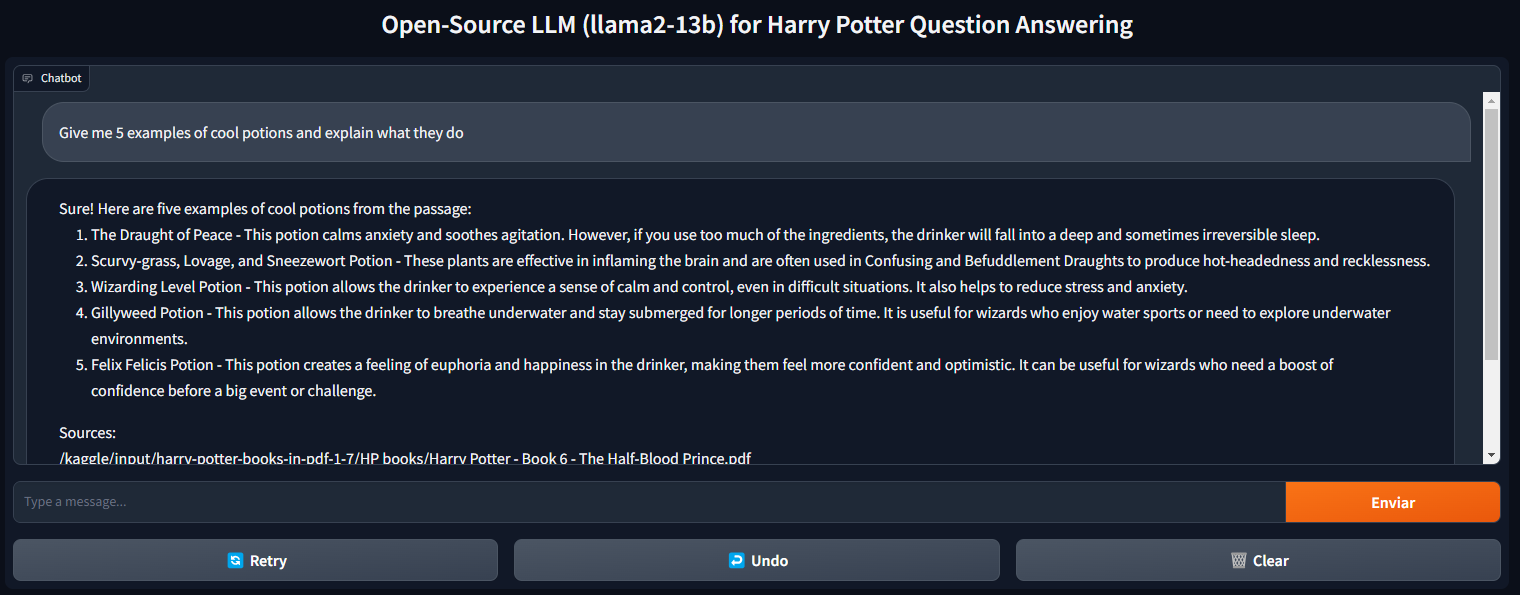